# Import lib, login HuggungFace, load dataset

## import lib

In [2]:
from transformers import pipeline 
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
from datasets import load_metric,load_dataset
from transformers import AutoTokenizer
import torch.nn as nn
import torch.nn.functional as F 

from utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device : ",device)


device :  cuda:0


## loging to Hugging face

In [3]:
# login to hugging face to push model 
from huggingface_hub import login
# load token from file  .env 
import os
from dotenv import load_dotenv
load_dotenv()
token = os.getenv("HF_AUTH_TOKEN")
login(token = token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/nghiaph/.cache/huggingface/token
Login successful


## Load the dataset

In [4]:
clinc = load_dataset("clinc_oos", "plus")
intents = clinc["train"].features["intent"]
# load the dataset
clinc = load_dataset("clinc_oos", "plus")
intents = clinc["train"].features["intent"]
# load metrics
accuracy_score = load_metric("accuracy")
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

# tokenizer the data
def tokenizer_text(batch):
    return student_tokenizer(batch["text"],truncation=True)
clinc_enc = clinc.map(tokenizer_text, batched=True)
clinc_enc = clinc_enc.rename_column("intent", "labels")

/tmp/ipykernel_3033465/24118507.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


## utils

In [5]:

def benchmark_the_model(pipe,
                  dataset=clinc["test"], 
                  intents=intents, 
                  query="""I want to transfer money to my friend.""", 
                  metric=load_metric("accuracy"),
                  optim_type = "BERT baseline"):
    print(optim_type)
    benchmark = PerformanceBenchmark(pipe, dataset, intents, query, metric ,optim_type)
    return benchmark.run_benchmark()
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [6]:
# iterate over the test set and make predictions
# y_true = []
# y_pred = []
# for example in clinc["test"]:
#     y_true.append(example["intent"])
#     y_pred.append(pipe(example["text"])[0]["label"])
#     print('text : ', example["text"])
#     print(pipe(example["text"]))
#     print(pipe(example["text"])[0]["label"])
#     break

# Baseline model

## Load the baseline model 

In [7]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline('text-classification', model=bert_ckpt, device=device) 
query = """I want to transfer money to my friend."""
pipe(query)

[{'label': 'transfer', 'score': 0.522346556186676}]

## Run benchmark and plot results

In [8]:
from utils import PerformanceBenchmark , plot_metrics
benchmark = PerformanceBenchmark(pipe, clinc["test"], intents, query,load_metric("accuracy"),optim_type="BERT baseline")
optim_type = "BERT baseline"
# perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))
perf_metrics = benchmark_the_model(pipe= pipe,optim_type = optim_type)

BERT baseline
Model size (MB) - 418.15
[]


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency ms - 0.002 +/- 0.048
Accuracy on test set - 0.867


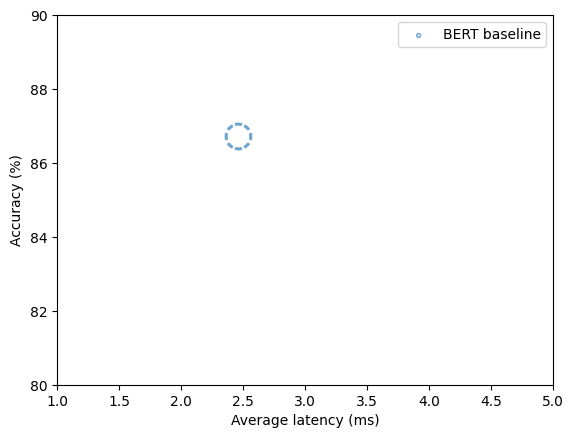

In [9]:
# plot the base model
plot_metrics(perf_metrics, optim_type)

# Define training args for training distillation model

In [10]:
from transformers import TrainingArguments 
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature = 2.0, **kwargs): 
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

## DistillationTrainer

In [11]:
from transformers import Trainer
class DistillationTrainer(Trainer):
    def __init__(self,*arg, teacher_model = None, **kwargs):
        super().__init__(*arg, **kwargs)
        self.teacher_model = teacher_model 
    def compute_loss(self, model, inputs, return_outputs=False):
        # extract loss from stuent 
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits
        student_loss = student_outputs.loss
        # extract loss from teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits
        klloss = nn.KLDivLoss(reduction="batchmean", log_target=False)
        loss_kd = klloss(
            F.log_softmax(student_logits / self.args.temperature, dim=-1),
            F.softmax(teacher_logits / self.args.temperature, dim=-1),
        ) * (self.args.temperature ** 2) # scale the loss by temperature
        # return weight student loss and kd loss
        loss = (1 - self.args.alpha) * student_loss + self.args.alpha * loss_kd
        return (loss, student_outputs) if return_outputs else loss
        


## Load the distillation model


In [12]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

# Train the distillation model with alpha = 1 
(no knowleadge from teacher)

### set up training student args

In [13]:
BATCH_SIZE  = 1280

finetune_ckpt = "distilbert-base-uncased-fineturned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetune_ckpt,
    evaluation_strategy = "epoch",
    num_train_epochs = 10,
    learning_rate = 4e-4,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    alpha = 1 , 
    weight_decay = 0.01, 
    push_to_hub = True,
    logging_steps = 10
)
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

### create custom model configuration

In [14]:
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = AutoConfig.from_pretrained(student_ckpt, 
                                            num_labels=num_labels, 
                                            id2label=id2label, 
                                            label2id=label2id
                                            
                                            )

In [15]:
from transformers import AutoModelForSequenceClassification 
def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config = student_config).to(device))

## train disllation model alpha =1

In [16]:
# load teacher model
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification.from_pretrained(teacher_ckpt,
                                                                    num_labels = num_labels).to(device))

distilbert_trainer = DistillationTrainer(
    model_init = student_init,
    teacher_model = teacher_model,
    args = student_training_args,
    train_dataset = clinc_enc["train"],
    eval_dataset = clinc_enc["validation"],
    compute_metrics = compute_metrics,
    tokenizer = student_tokenizer,
)
distilbert_trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.009200,0.603215,0.488065
2,0.556100,0.206305,0.787742
3,0.248100,0.084343,0.897742
4,0.119400,0.052456,0.922258
5,0.056300,0.039772,0.932581
6,0.047400,0.035062,0.936452
7,0.042300,0.031776,0.935806
8,0.039700,0.030609,0.937742
9,0.037800,0.029733,0.938065
10,0.035900,0.029162,0.938387


TrainOutput(global_step=120, training_loss=0.19196370591719944, metrics={'train_runtime': 127.8736, 'train_samples_per_second': 1192.584, 'train_steps_per_second': 0.938, 'total_flos': 1102691491769280.0, 'train_loss': 0.19196370591719944, 'epoch': 10.0})

In [17]:
distilbert_trainer.push_to_hub("training completed!")

training_args.bin:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

'https://huggingface.co/phnghiapro/distilbert-base-uncased-fineturned-clinc/tree/main/'

In [18]:
finetune_ckpt = "phnghiapro/distilbert-base-uncased-fineturned-clinc"
pipe = pipeline('text-classification', model=finetune_ckpt, device=device)


In [19]:
optim_type = "DistilBERT"
perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))



DistilBERT
Model size (MB) - 255.88
[]


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency ms - 0.001 +/- 0.046
Accuracy on test set - 0.853


## plot the results model with alpha =1

In [20]:
df = pd.DataFrame.from_dict(perf_metrics, orient='index')
df.head()

,size_mb,time_avg_ms,time_std_ms,accuracy
BERT baseline,418.149377,2.450562,0.047590,0.867273
DistilBERT,255.882840,1.511929,0.045796,0.853273


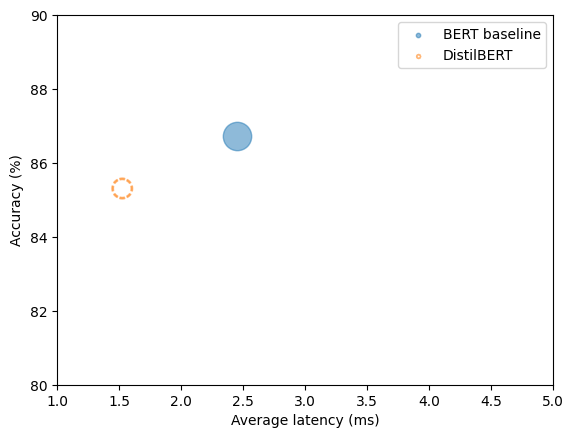

In [21]:
#plot the metrics
plot_metrics(perf_metrics, optim_type)

# Train the distillation model with alpha = grid search

## Grid Search parameters

In [22]:
# def hp_space(trial):
#     return {
#     "alpha": trial.suggest_float("alpha", 0, 1),
#     "temperature": trial.suggest_int("temperature", 2, 20),
#     "learning_rate": trial.suggest_float("learning_rate", 3e-4, 5e-4),
#     }
# best_run = distilbert_trainer.hyperparameter_search(
#                                     n_trials=20, 
#                                     direction="maximize", 
#                                     hp_space=hp_space)
# print(best_run)


In [23]:
# print(best_run)
best_run = {}
#BestRun(run_id='0', objective=0.9467741935483871, hyperparameters={'alpha': 0.685702970499929, 'temperature': 3}, run_summary=None)
best_run["hyperparameters"] = {'alpha': 0.685702970499929, 'temperature': 3}

In [24]:
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)

for k,v in best_run["hyperparameters"].items():
    setattr(student_training_args, k, v)
 
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model, 
    args=student_training_args,
    train_dataset=clinc_enc['train'], 
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, 
    tokenizer=student_tokenizer
    )
distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,1.969200,1.348570,0.657419
2,1.186700,0.540853,0.888387
3,0.561400,0.284472,0.938710
4,0.295000,0.223382,0.947097
5,0.172900,0.202132,0.948710
6,0.157400,0.194220,0.951290
7,0.147700,0.189532,0.950968
8,0.144600,0.186990,0.949677
9,0.140500,0.185560,0.949355
10,0.138200,0.185177,0.949032


TrainOutput(global_step=120, training_loss=0.43827982544898986, metrics={'train_runtime': 128.9889, 'train_samples_per_second': 1182.273, 'train_steps_per_second': 0.93, 'total_flos': 1102691491769280.0, 'train_loss': 0.43827982544898986, 'epoch': 10.0})

In [25]:
distil_trainer.push_to_hub("Training complete")


training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

'https://huggingface.co/phnghiapro/distilbert-base-uncased-distilled-clinc/tree/main/'

## Benchmark Distilllerd model

In [26]:
distilled_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
pipe = pipeline('text-classification', model=distilled_ckpt, device=device)
optim_type = "Distillation"
perf_metrics.update(benchmark_the_model(pipe= pipe,optim_type = optim_type))

Distillation
Model size (MB) - 255.88
[]


/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency ms - 0.002 +/- 0.049
Accuracy on test set - 0.877


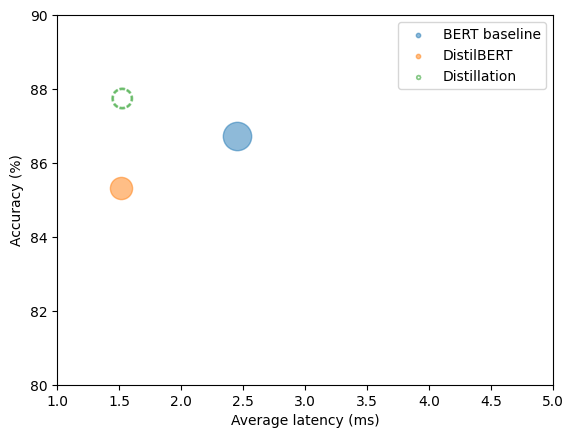

In [27]:
plot_metrics(perf_metrics, optim_type)
